# K-Fold CV for Boosting Methods Using SKLearn 

In [2]:
#Importing required libraries
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import wfdb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from numpy import mean
from numpy import absolute
from numpy import sqrt
import pandas as pd
import random
import statistics

In [3]:
import xgboost as xgb
from sklearn import metrics
from lightgbm import LGBMClassifier

import lightgbm
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 70 #display 70 dpi in Jupyter Notebook, may consider100 dpi 
plt.rcParams['savefig.dpi'] = 300 #define 300 dpi for saving figures

import seaborn as sns
## here are some settings 
sns.set_style('whitegrid')
sns.set(rc={"figure.dpi":70, 'savefig.dpi':300}) #defining dpi setting
sns.set_context('notebook')
sns.set_style("ticks")
from IPython.display import set_matplotlib_formats

### To load sklearn dataset
sklearn.datasets.load_breast_cancer(*, return_X_y=False, as_frame=False)[source]¶

Load and return the breast cancer wisconsin dataset (classification).

In [5]:
#data = load_breast_cancer(as_frame = True); 
#df = data.frame; 
#print(df.shape)
# In this block use the code we looked at on 6/30 as a reference to save our rr-intervals as a .
rlist = []
records = 'mit-bih-raw\RECORDS' # Replace the _______ with the name of the records file in your MIT-BIH data folder
with open(records) as rfile: #Then we open the file 
                             #The 'with' command only opens the file while we are in it. Automatically closes the file when we're not
    for record in rfile:  # Then we iterate through the lines in the file
        record = record[0:len(record)-1] # Remove any erronious new line characters at the end ('\n')
        rlist.append(record) # Then build an array with it
        

###### Step 1: Initialize all Arrays
             # Below, replace all of the ___ with the command that declares an array/list
             # hint: https://stackoverflow.com/questions/1514553/how-to-declare-an-array-in-python
samples = [] # will house the samples of all subjects
good_list = [] # will list the names of the subjects we successfully extracted
bad_list = [] # will house the names of the subjects we failed to extract
qrs = [] # will house the indices of R-Peaks for all subjects
atr_label = [] # will house the labels for each rhythm annotation for all subjects
atr_locs = [] # will house the locations corresponding to the rhythm annotation labels


###### Step 2: Extract Information
for x in tqdm(rlist): #this will iterate through te records that we found above
  
    try: # A try statement will run the except statement if for some reason the try commands fail
         # In this case I use the try statement because one of the subjects has no signal data causing failure
         # I then use bad_list and good_list so that all of the indices in rlist match with the arrays we initialized in Step 1, above
        ######################################################
            # Below find the wfdb function that will return the information that is described below 
        # Then replace _____ with the correct function call
        samp = wfdb.rdsamp('mit-bih-raw/'+x) # wfdb._____(file_location) will read the signal & header data and return a 2 value array
            # samp[0] - the signal data is the raw reading from the ecg. Each value is a sample taken.
            # samp[1] - the header data includes things about the signal data such as:
              # samples per section, denoted 'fs'
              # number of signals, denoted 'n_sig'
            
        ######################################################
        samples.append(samp) #add it to our array for all subject
            #What is our file extension that has the annotation we want? Find it here and replace _____ with it 
            #hint: READ THE VARIABLE NAMES!!!!
        qrs_tmp = wfdb.rdann('mit-bih-raw/'+x, extension='qrs') #extract the QRS Info
        qrs_locs = np.array(qrs_tmp.sample, dtype='int') #Get just the loccation of R-Peaks from the QRS Info
        qrs.append(qrs_locs) # Add to our array for all subjects
        
            #Do the same thing here
        atr = wfdb.rdann('mit-bih-raw/'+x,extension='atr') #extract the atr info which stores the rhythm type(s) over the whole signal
        atr_label.append(atr.aux_note) # aux_note stores the type of rhythm - main two are '(N' for normal and '(AFIB' for AFIB
        atr_locs.append(np.append(atr.sample, len(samp[0]))) #I add the length of the whole sample to the end for better visualization later
        
        good_list.append(x) # when all extraction is successful append the record name to good_list
    except Exception as exep:
        print(exep) # Alert the user of an exception
        bad_list.append(x) # add to the bad list

        

  0%|          | 0/25 [00:00<?, ?it/s]

sampto must be greater than sampfrom
sampto must be greater than sampfrom


100%|██████████| 25/25 [00:21<00:00,  1.15it/s]


In [6]:
features_df_list = []
for subject in good_list:
    data = pd.read_csv(f'subject-features-dataframes/subject{subject}.csv')
    data = data.assign(Subject = subject)
    #print(data)
    features_df_list.append(data)
#features_maindf = pd.concat(features_df_list, ignore_index = True)

In [7]:
#df.head(5)
# df.info()
# df.describe()
#features_df_list[0]
counter = 0
testing_arr = []
training_arr = []
for subject in features_df_list:
    if counter != 22:
        training_arr.append(subject)
    else:
        testing_arr.append(subject)
    counter += 1
    
print(len(training_arr))

22


In [8]:
features_maindf = pd.concat(features_df_list, ignore_index = True)
print(features_maindf.columns)

Index(['Unnamed: 0', 'AppEn', 'SampEn', 'CosEn', 'RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',
       'Rhythm', 'Subject'],
      dtype='object')


# CatBoosting

In [11]:
# https://catboost.ai/en/docs/concepts/python-quickstart
import catboost as cb
from catboost import CatBoostClassifier


print ('catboost version', cb.__version__)

catboost version 1.0.6


In [10]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
iterations_list = []
max_depth_list = []
x_values = ['AppEn', 'SampEn', 'CosEn', 'RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility']
y_values = ['Rhythm']
#for df in features_df_list:
df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()
    
    # Create CatBoost model
    temp_model = CatBoostClassifier(learning_rate = 0.1, loss_function='Logloss')
    param_distributions = {'iterations': randint(105, 110),
                           'depth': randint(7,10)}
    search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
    search.fit(X_train, y_train)


    model = CatBoostClassifier(iterations=search.best_params_['iterations'], learning_rate=0.1, depth=search.best_params_['depth'], loss_function='Logloss')
    model.fit(X_train, y_train)
    
    iterations_list.append(search.best_params_['iterations'])
    max_depth_list.append(search.best_params_['depth'])
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
    Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
                          index = (X_train.columns))
    Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'r')
    plt.xlabel('Variable Importance')
    plt.gca().legend_ = None
    #plt.savefig('plot1.png')


elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

0:	learn: 0.6163240	total: 145ms	remaining: 15.1s
1:	learn: 0.5525459	total: 151ms	remaining: 7.8s
2:	learn: 0.4986852	total: 157ms	remaining: 5.33s
3:	learn: 0.4531003	total: 162ms	remaining: 4.08s
4:	learn: 0.4146073	total: 166ms	remaining: 3.32s
5:	learn: 0.3810135	total: 170ms	remaining: 2.81s
6:	learn: 0.3511224	total: 174ms	remaining: 2.44s
7:	learn: 0.3256266	total: 178ms	remaining: 2.16s
8:	learn: 0.3033212	total: 182ms	remaining: 1.95s
9:	learn: 0.2827909	total: 187ms	remaining: 1.77s
10:	learn: 0.2653927	total: 191ms	remaining: 1.63s
11:	learn: 0.2500381	total: 195ms	remaining: 1.51s
12:	learn: 0.2359501	total: 199ms	remaining: 1.41s
13:	learn: 0.2229209	total: 203ms	remaining: 1.32s
14:	learn: 0.2111677	total: 208ms	remaining: 1.25s
15:	learn: 0.2013561	total: 212ms	remaining: 1.18s
16:	learn: 0.1920376	total: 217ms	remaining: 1.12s
17:	learn: 0.1839321	total: 221ms	remaining: 1.07s
18:	learn: 0.1768967	total: 225ms	remaining: 1.02s
19:	learn: 0.1703663	total: 229ms	remainin

90:	learn: 0.1127459	total: 411ms	remaining: 63.2ms
91:	learn: 0.1124872	total: 416ms	remaining: 58.8ms
92:	learn: 0.1123282	total: 420ms	remaining: 54.2ms
93:	learn: 0.1120620	total: 424ms	remaining: 49.6ms
94:	learn: 0.1118689	total: 430ms	remaining: 45.3ms
95:	learn: 0.1116665	total: 434ms	remaining: 40.7ms
96:	learn: 0.1115066	total: 438ms	remaining: 36.1ms
97:	learn: 0.1113434	total: 442ms	remaining: 31.6ms
98:	learn: 0.1111765	total: 448ms	remaining: 27.2ms
99:	learn: 0.1111020	total: 452ms	remaining: 22.6ms
100:	learn: 0.1109019	total: 456ms	remaining: 18.1ms
101:	learn: 0.1106900	total: 461ms	remaining: 13.6ms
102:	learn: 0.1104975	total: 466ms	remaining: 9.05ms
103:	learn: 0.1104081	total: 470ms	remaining: 4.52ms
104:	learn: 0.1102567	total: 474ms	remaining: 0us
0:	learn: 0.6174577	total: 4.7ms	remaining: 489ms
1:	learn: 0.5543191	total: 9.79ms	remaining: 504ms
2:	learn: 0.5019338	total: 13.7ms	remaining: 467ms
3:	learn: 0.4567597	total: 18.1ms	remaining: 457ms
4:	learn: 0.418

64:	learn: 0.1000294	total: 290ms	remaining: 178ms
65:	learn: 0.0997387	total: 294ms	remaining: 174ms
66:	learn: 0.0994679	total: 299ms	remaining: 170ms
67:	learn: 0.0992485	total: 304ms	remaining: 165ms
68:	learn: 0.0989795	total: 308ms	remaining: 161ms
69:	learn: 0.0987381	total: 313ms	remaining: 156ms
70:	learn: 0.0985352	total: 317ms	remaining: 152ms
71:	learn: 0.0982765	total: 322ms	remaining: 147ms
72:	learn: 0.0980533	total: 326ms	remaining: 143ms
73:	learn: 0.0977619	total: 330ms	remaining: 138ms
74:	learn: 0.0976277	total: 334ms	remaining: 134ms
75:	learn: 0.0974643	total: 338ms	remaining: 129ms
76:	learn: 0.0972721	total: 343ms	remaining: 125ms
77:	learn: 0.0970638	total: 347ms	remaining: 120ms
78:	learn: 0.0968170	total: 351ms	remaining: 116ms
79:	learn: 0.0966199	total: 356ms	remaining: 111ms
80:	learn: 0.0964728	total: 360ms	remaining: 107ms
81:	learn: 0.0962759	total: 365ms	remaining: 102ms
82:	learn: 0.0960328	total: 370ms	remaining: 98ms
83:	learn: 0.0957785	total: 374m

KeyboardInterrupt: 

In [11]:
prob = model.predict_proba(df.loc[:100,x_values])
prob

array([[0.02299783, 0.97700217],
       [0.1222193 , 0.8777807 ],
       [0.11476138, 0.88523862],
       [0.1041396 , 0.8958604 ],
       [0.10454267, 0.89545733],
       [0.19655836, 0.80344164],
       [0.12784683, 0.87215317],
       [0.15841762, 0.84158238],
       [0.09126407, 0.90873593],
       [0.43241961, 0.56758039],
       [0.47470499, 0.52529501],
       [0.48516942, 0.51483058],
       [0.99798385, 0.00201615],
       [0.06338436, 0.93661564],
       [0.33524155, 0.66475845],
       [0.7271279 , 0.2728721 ],
       [0.12275226, 0.87724774],
       [0.46095049, 0.53904951],
       [0.24882904, 0.75117096],
       [0.06556445, 0.93443555],
       [0.09657642, 0.90342358],
       [0.25720644, 0.74279356],
       [0.98996479, 0.01003521],
       [0.14435398, 0.85564602],
       [0.03468451, 0.96531549],
       [0.01978846, 0.98021154],
       [0.04286297, 0.95713703],
       [0.06307118, 0.93692882],
       [0.02791608, 0.97208392],
       [0.1943125 , 0.8056875 ],
       [0.

In [17]:
len("Predicted with 44.5% confidence on average.")
"Predicted with 44.5% confidence on average."[:-10:]

'Predicted with 44.5% confidence o'

In [11]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
print(iterations_list)
print(max_depth_list)

temp_list = []
temp_idx = []
for acc in acc_score:
    if acc >= 0.95:
        temp_list.append(acc)
        temp_idx.append(acc_score.index(acc))
for idx in temp_idx:
    print(iterations_list[idx])
    print(max_depth_list[idx])
    
#[[23080  1663]
# [ 1777 18448]]
# Accuracy of each fold: 
#  [0.9124713958810069, 0.9529411764705882, 0.9968513853904282, 0.9256594724220624, 0.9979101358411703, 0.9521298174442191, 0.8075665576833255, 0.9972770592239619, 0.9412650602409639, 0.9691289966923925, 0.9832123411978222, 0.990667623833453, 0.8027210884353742, 0.9668789808917198, 0.541631973355537, 0.9902525476295968, 0.9910897875257025, 0.9838430467397576, 0.7616229923922232, 0.9736118746564046, 0.9970059880239521, 0.9968612680477087, 0.9974630021141649]

# Avg accuracy : 
# 0.9317418944405887

# Std of accuracy : 
# 0.10641487333785117

[[23352  1391]
 [ 1321 18904]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.95     24743
           1       0.93      0.93      0.93     20225

    accuracy                           0.94     44968
   macro avg       0.94      0.94      0.94     44968
weighted avg       0.94      0.94      0.94     44968

[0.9204805491990846, 0.9606490872210953, 0.9962216624685138, 0.842925659472422, 0.9921630094043887, 0.9687626774847871, 0.7585240541802896, 0.9959155888359428, 0.9412650602409639, 0.9669239250275634, 0.9827586206896551, 0.9863603732950467, 0.780952380952381, 0.9828025477707006, 0.7939217318900916, 0.969428444838281, 0.9945167923235092, 0.9982688978649741, 0.9167371090448013, 0.9840571742715778, 0.9940119760479041, 0.9899560577526679, 0.9923890063424947]
888.8862938999999
[106, 109, 105, 105, 105, 105, 108, 109, 105, 106, 109, 106, 106, 106, 106, 105, 107, 105, 106, 106, 106, 105, 106]
[9, 8, 9, 9, 9, 9, 8, 8, 9, 9, 8, 9, 9, 9, 9, 9, 8

In [12]:
print(statistics.mode(iterations_list))
print(statistics.mode(max_depth_list))

106
9


In [ ]:
# Accuracy of each fold: 
#  [0.9124713958810069, 0.9525354969574037, 0.9974811083123426, 0.9262589928057554, 0.9979101358411703, 0.9529411764705882, 0.8066324147594582, 0.9972770592239619, 0.9412650602409639, 0.9696802646085998, 0.9832123411978222, 0.9899497487437185, 0.8022675736961451, 0.967515923566879, 0.5441298917568693, 0.9889233495790872, 0.9910897875257025, 0.9861511829197923, 0.760777683854607, 0.9741616272677295, 0.9970059880239521, 0.997489014438167, 0.9974630021141649]

# Avg accuracy : 
# 0.9319387052080821

# Std of accuracy : 
# 0.10621247183547902
# [[23081  1662]
#  [ 1770 18455]]

# ALL

In [15]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
iterations_list = []
max_depth_list = []

from sklearn.inspection import permutation_importance
x_values = ['AppEn','SampEn','RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',]
y_values = ['Rhythm']
#for df in features_df_list:

zero_values_list = [0] * len(x_values)

perm_imp_dict = dict(zip(x_values,zero_values_list))

# Initialize dataframe with zeros
average_importance = pd.DataFrame({'Importance':np.zeros(len(x_values))}, 
                                  index = x_values)

counts = pd.DataFrame({'Count':np.zeros(len(x_values))}, 
                                  index = x_values)



df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()
    
    # Create CatBoost model
#     temp_model = CatBoostClassifier(learning_rate = 0.1, loss_function='Logloss')
#     param_distributions = {'iterations': randint(105, 110),
#                            'depth': randint(7,10)}
#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)


    model = CatBoostClassifier(iterations=106, learning_rate=0.1, depth=9, loss_function='Logloss')
    model.fit(X_train, y_train)
    
#     iterations_list.append(search.best_params_['iterations'])
#     max_depth_list.append(search.best_params_['depth'])
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
#     Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
#                           index = (X_train.columns))
#     Importance.sort_values(by = 'Importance', 
#                        axis = 0, 
#                        ascending = True).plot(kind = 'barh', 
#                                               color = 'r')
#     plt.xlabel('Variable Importance')
#     plt.gca().legend_ = None
    #plt.savefig('plot1.png')
    
    
    temp_importance = pd.DataFrame({'Importance':model.feature_importances_*100}, 
                          index = X_train.columns)
    for feature in X_train.columns:
        average_importance.loc[feature, 'Importance'] += temp_importance.loc[feature, 'Importance']
        counts.loc[feature, 'Count'] += 1
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

    for i in range(0,len(x_values)):
        perm_imp_dict[x_values[i]] += result.importances_mean[i]*100



elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

for i in range(0,len(x_values)):
    perm_imp_dict[x_values[i]] = perm_imp_dict[x_values[i]] / 23

perm_imp_dict["Catboost"] = 100
perm_imp_df = pd.DataFrame([perm_imp_dict])

perm_imp_df_t = perm_imp_df.T
perm_imp_df_t.columns = ["Importance"]
perm_imp_df_t.sort_values(by=['Importance'],ascending=False)

#perm_imp_df_t.to_csv('perm_imp.csv',mode='a',header=False)

perm_imp_df_t = perm_imp_df_t.drop(["Catboost"])


0:	learn: 0.6167182	total: 10.1ms	remaining: 1.06s
1:	learn: 0.5559603	total: 19.6ms	remaining: 1.02s
2:	learn: 0.5028256	total: 28.8ms	remaining: 988ms
3:	learn: 0.4585780	total: 37.6ms	remaining: 960ms
4:	learn: 0.4200577	total: 46.5ms	remaining: 940ms
5:	learn: 0.3862867	total: 54.9ms	remaining: 914ms
6:	learn: 0.3574216	total: 63.6ms	remaining: 900ms
7:	learn: 0.3319283	total: 72.4ms	remaining: 887ms
8:	learn: 0.3092278	total: 81.6ms	remaining: 879ms
9:	learn: 0.2894396	total: 90.3ms	remaining: 867ms
10:	learn: 0.2720838	total: 98.8ms	remaining: 853ms
11:	learn: 0.2564408	total: 107ms	remaining: 838ms
12:	learn: 0.2422773	total: 115ms	remaining: 826ms
13:	learn: 0.2298958	total: 124ms	remaining: 814ms
14:	learn: 0.2186595	total: 132ms	remaining: 802ms
15:	learn: 0.2088439	total: 141ms	remaining: 793ms
16:	learn: 0.1999329	total: 149ms	remaining: 782ms
17:	learn: 0.1920095	total: 158ms	remaining: 773ms
18:	learn: 0.1845163	total: 166ms	remaining: 762ms
19:	learn: 0.1780916	total: 17

63:	learn: 0.1167393	total: 579ms	remaining: 380ms
64:	learn: 0.1163804	total: 589ms	remaining: 371ms
65:	learn: 0.1161061	total: 598ms	remaining: 362ms
66:	learn: 0.1158575	total: 607ms	remaining: 353ms
67:	learn: 0.1155564	total: 615ms	remaining: 344ms
68:	learn: 0.1153232	total: 624ms	remaining: 334ms
69:	learn: 0.1150295	total: 632ms	remaining: 325ms
70:	learn: 0.1147455	total: 640ms	remaining: 316ms
71:	learn: 0.1145636	total: 649ms	remaining: 306ms
72:	learn: 0.1142830	total: 657ms	remaining: 297ms
73:	learn: 0.1140382	total: 666ms	remaining: 288ms
74:	learn: 0.1137783	total: 674ms	remaining: 279ms
75:	learn: 0.1135088	total: 683ms	remaining: 270ms
76:	learn: 0.1132887	total: 693ms	remaining: 261ms
77:	learn: 0.1130671	total: 703ms	remaining: 252ms
78:	learn: 0.1127826	total: 712ms	remaining: 243ms
79:	learn: 0.1125008	total: 722ms	remaining: 235ms
80:	learn: 0.1122574	total: 731ms	remaining: 226ms
81:	learn: 0.1120803	total: 740ms	remaining: 217ms
82:	learn: 0.1118567	total: 749

21:	learn: 0.1634178	total: 201ms	remaining: 766ms
22:	learn: 0.1589596	total: 210ms	remaining: 757ms
23:	learn: 0.1546834	total: 219ms	remaining: 748ms
24:	learn: 0.1508688	total: 228ms	remaining: 738ms
25:	learn: 0.1474873	total: 236ms	remaining: 728ms
26:	learn: 0.1445040	total: 245ms	remaining: 717ms
27:	learn: 0.1415367	total: 254ms	remaining: 707ms
28:	learn: 0.1390049	total: 262ms	remaining: 697ms
29:	learn: 0.1366950	total: 271ms	remaining: 686ms
30:	learn: 0.1345019	total: 280ms	remaining: 676ms
31:	learn: 0.1327199	total: 288ms	remaining: 666ms
32:	learn: 0.1310223	total: 297ms	remaining: 657ms
33:	learn: 0.1294393	total: 306ms	remaining: 647ms
34:	learn: 0.1281676	total: 314ms	remaining: 637ms
35:	learn: 0.1265821	total: 323ms	remaining: 627ms
36:	learn: 0.1253513	total: 331ms	remaining: 618ms
37:	learn: 0.1241500	total: 340ms	remaining: 608ms
38:	learn: 0.1231582	total: 348ms	remaining: 598ms
39:	learn: 0.1219776	total: 357ms	remaining: 589ms
40:	learn: 0.1210417	total: 366

84:	learn: 0.1136661	total: 767ms	remaining: 189ms
85:	learn: 0.1134771	total: 776ms	remaining: 181ms
86:	learn: 0.1132413	total: 785ms	remaining: 171ms
87:	learn: 0.1131116	total: 793ms	remaining: 162ms
88:	learn: 0.1129440	total: 802ms	remaining: 153ms
89:	learn: 0.1128608	total: 810ms	remaining: 144ms
90:	learn: 0.1126580	total: 820ms	remaining: 135ms
91:	learn: 0.1125412	total: 828ms	remaining: 126ms
92:	learn: 0.1124052	total: 837ms	remaining: 117ms
93:	learn: 0.1121964	total: 846ms	remaining: 108ms
94:	learn: 0.1120567	total: 855ms	remaining: 99ms
95:	learn: 0.1119003	total: 865ms	remaining: 90.1ms
96:	learn: 0.1116801	total: 874ms	remaining: 81.1ms
97:	learn: 0.1114591	total: 883ms	remaining: 72.1ms
98:	learn: 0.1112508	total: 892ms	remaining: 63ms
99:	learn: 0.1110431	total: 905ms	remaining: 54.3ms
100:	learn: 0.1109344	total: 915ms	remaining: 45.3ms
101:	learn: 0.1106875	total: 925ms	remaining: 36.3ms
102:	learn: 0.1105206	total: 935ms	remaining: 27.2ms
103:	learn: 0.1103399	t

40:	learn: 0.1089816	total: 384ms	remaining: 609ms
41:	learn: 0.1079891	total: 394ms	remaining: 600ms
42:	learn: 0.1070174	total: 404ms	remaining: 592ms
43:	learn: 0.1062602	total: 413ms	remaining: 582ms
44:	learn: 0.1055142	total: 422ms	remaining: 572ms
45:	learn: 0.1047681	total: 431ms	remaining: 563ms
46:	learn: 0.1040709	total: 441ms	remaining: 553ms
47:	learn: 0.1035068	total: 450ms	remaining: 544ms
48:	learn: 0.1029623	total: 459ms	remaining: 534ms
49:	learn: 0.1023946	total: 469ms	remaining: 525ms
50:	learn: 0.1018940	total: 478ms	remaining: 515ms
51:	learn: 0.1014015	total: 486ms	remaining: 505ms
52:	learn: 0.1008551	total: 495ms	remaining: 495ms
53:	learn: 0.1004696	total: 504ms	remaining: 485ms
54:	learn: 0.1001206	total: 513ms	remaining: 475ms
55:	learn: 0.0997517	total: 521ms	remaining: 465ms
56:	learn: 0.0993305	total: 530ms	remaining: 456ms
57:	learn: 0.0990317	total: 539ms	remaining: 446ms
58:	learn: 0.0987466	total: 548ms	remaining: 437ms
59:	learn: 0.0983602	total: 557

95:	learn: 0.1115944	total: 943ms	remaining: 98.2ms
96:	learn: 0.1114077	total: 952ms	remaining: 88.4ms
97:	learn: 0.1112530	total: 961ms	remaining: 78.5ms
98:	learn: 0.1110543	total: 970ms	remaining: 68.6ms
99:	learn: 0.1108875	total: 979ms	remaining: 58.7ms
100:	learn: 0.1107509	total: 987ms	remaining: 48.9ms
101:	learn: 0.1105002	total: 997ms	remaining: 39.1ms
102:	learn: 0.1103132	total: 1s	remaining: 29.3ms
103:	learn: 0.1101761	total: 1.01s	remaining: 19.5ms
104:	learn: 0.1099877	total: 1.02s	remaining: 9.74ms
105:	learn: 0.1097918	total: 1.03s	remaining: 0us
0:	learn: 0.6169135	total: 9.63ms	remaining: 1.01s
1:	learn: 0.5561695	total: 19.2ms	remaining: 998ms
2:	learn: 0.5030305	total: 28.6ms	remaining: 981ms
3:	learn: 0.4577742	total: 37.6ms	remaining: 958ms
4:	learn: 0.4198858	total: 47ms	remaining: 950ms
5:	learn: 0.3867135	total: 55.5ms	remaining: 925ms
6:	learn: 0.3577992	total: 64.2ms	remaining: 909ms
7:	learn: 0.3326580	total: 73ms	remaining: 894ms
8:	learn: 0.3100931	tota

65:	learn: 0.1168496	total: 576ms	remaining: 349ms
66:	learn: 0.1166444	total: 585ms	remaining: 340ms
67:	learn: 0.1163709	total: 594ms	remaining: 332ms
68:	learn: 0.1161446	total: 603ms	remaining: 323ms
69:	learn: 0.1159031	total: 612ms	remaining: 315ms
70:	learn: 0.1156539	total: 621ms	remaining: 306ms
71:	learn: 0.1153375	total: 629ms	remaining: 297ms
72:	learn: 0.1150886	total: 638ms	remaining: 288ms
73:	learn: 0.1148217	total: 647ms	remaining: 280ms
74:	learn: 0.1145094	total: 656ms	remaining: 271ms
75:	learn: 0.1142317	total: 665ms	remaining: 263ms
76:	learn: 0.1140147	total: 674ms	remaining: 254ms
77:	learn: 0.1138014	total: 683ms	remaining: 245ms
78:	learn: 0.1136078	total: 692ms	remaining: 236ms
79:	learn: 0.1133516	total: 701ms	remaining: 228ms
80:	learn: 0.1131380	total: 709ms	remaining: 219ms
81:	learn: 0.1129470	total: 718ms	remaining: 210ms
82:	learn: 0.1126782	total: 727ms	remaining: 202ms
83:	learn: 0.1125134	total: 737ms	remaining: 193ms
84:	learn: 0.1122550	total: 746

20:	learn: 0.1787417	total: 195ms	remaining: 790ms
21:	learn: 0.1736222	total: 204ms	remaining: 779ms
22:	learn: 0.1688522	total: 214ms	remaining: 771ms
23:	learn: 0.1647147	total: 222ms	remaining: 759ms
24:	learn: 0.1609524	total: 232ms	remaining: 750ms
25:	learn: 0.1574978	total: 240ms	remaining: 739ms
26:	learn: 0.1544341	total: 250ms	remaining: 732ms
27:	learn: 0.1516766	total: 259ms	remaining: 721ms
28:	learn: 0.1490031	total: 268ms	remaining: 711ms
29:	learn: 0.1465307	total: 277ms	remaining: 701ms
30:	learn: 0.1441895	total: 286ms	remaining: 692ms
31:	learn: 0.1422203	total: 296ms	remaining: 685ms
32:	learn: 0.1403107	total: 305ms	remaining: 674ms
33:	learn: 0.1386907	total: 314ms	remaining: 666ms
34:	learn: 0.1370706	total: 323ms	remaining: 655ms
35:	learn: 0.1354933	total: 332ms	remaining: 645ms
36:	learn: 0.1341424	total: 340ms	remaining: 635ms
37:	learn: 0.1330619	total: 349ms	remaining: 624ms
38:	learn: 0.1317874	total: 358ms	remaining: 614ms
39:	learn: 0.1306332	total: 366

83:	learn: 0.0952520	total: 746ms	remaining: 195ms
84:	learn: 0.0949856	total: 755ms	remaining: 187ms
85:	learn: 0.0947450	total: 765ms	remaining: 178ms
86:	learn: 0.0945700	total: 773ms	remaining: 169ms
87:	learn: 0.0943435	total: 783ms	remaining: 160ms
88:	learn: 0.0941614	total: 792ms	remaining: 151ms
89:	learn: 0.0940145	total: 802ms	remaining: 143ms
90:	learn: 0.0937263	total: 811ms	remaining: 134ms
91:	learn: 0.0936096	total: 819ms	remaining: 125ms
92:	learn: 0.0934459	total: 828ms	remaining: 116ms
93:	learn: 0.0932831	total: 836ms	remaining: 107ms
94:	learn: 0.0931270	total: 845ms	remaining: 97.8ms
95:	learn: 0.0930331	total: 853ms	remaining: 88.8ms
96:	learn: 0.0928869	total: 862ms	remaining: 80ms
97:	learn: 0.0926936	total: 871ms	remaining: 71.1ms
98:	learn: 0.0924990	total: 880ms	remaining: 62.2ms
99:	learn: 0.0923426	total: 889ms	remaining: 53.3ms
100:	learn: 0.0922330	total: 898ms	remaining: 44.5ms
101:	learn: 0.0920807	total: 907ms	remaining: 35.6ms
102:	learn: 0.0919133	t

42:	learn: 0.1164887	total: 399ms	remaining: 585ms
43:	learn: 0.1158733	total: 408ms	remaining: 575ms
44:	learn: 0.1152522	total: 417ms	remaining: 565ms
45:	learn: 0.1146316	total: 426ms	remaining: 555ms
46:	learn: 0.1140190	total: 435ms	remaining: 546ms
47:	learn: 0.1135123	total: 444ms	remaining: 537ms
48:	learn: 0.1129550	total: 453ms	remaining: 527ms
49:	learn: 0.1123734	total: 462ms	remaining: 518ms
50:	learn: 0.1118447	total: 471ms	remaining: 508ms
51:	learn: 0.1113686	total: 480ms	remaining: 498ms
52:	learn: 0.1109028	total: 489ms	remaining: 489ms
53:	learn: 0.1104607	total: 498ms	remaining: 479ms
54:	learn: 0.1101197	total: 506ms	remaining: 470ms
55:	learn: 0.1098252	total: 516ms	remaining: 460ms
56:	learn: 0.1094354	total: 525ms	remaining: 451ms
57:	learn: 0.1091219	total: 534ms	remaining: 442ms
58:	learn: 0.1087913	total: 544ms	remaining: 433ms
59:	learn: 0.1084307	total: 553ms	remaining: 424ms
60:	learn: 0.1081620	total: 562ms	remaining: 415ms
61:	learn: 0.1078914	total: 572

99:	learn: 0.1092163	total: 959ms	remaining: 57.5ms
100:	learn: 0.1090216	total: 968ms	remaining: 47.9ms
101:	learn: 0.1088403	total: 977ms	remaining: 38.3ms
102:	learn: 0.1086436	total: 986ms	remaining: 28.7ms
103:	learn: 0.1084507	total: 995ms	remaining: 19.1ms
104:	learn: 0.1082135	total: 1s	remaining: 9.57ms
105:	learn: 0.1080384	total: 1.01s	remaining: 0us
0:	learn: 0.6175963	total: 12.2ms	remaining: 1.28s
1:	learn: 0.5576429	total: 23.2ms	remaining: 1.21s
2:	learn: 0.5051400	total: 32.8ms	remaining: 1.13s
3:	learn: 0.4611626	total: 42.3ms	remaining: 1.08s
4:	learn: 0.4230039	total: 52.1ms	remaining: 1.05s
5:	learn: 0.3898037	total: 61.2ms	remaining: 1.02s
6:	learn: 0.3612699	total: 71.1ms	remaining: 1s
7:	learn: 0.3362544	total: 80.4ms	remaining: 985ms
8:	learn: 0.3138670	total: 90.2ms	remaining: 973ms
9:	learn: 0.2944830	total: 100ms	remaining: 962ms
10:	learn: 0.2773678	total: 110ms	remaining: 947ms
11:	learn: 0.2619476	total: 119ms	remaining: 934ms
12:	learn: 0.2480551	total: 

59:	learn: 0.1206353	total: 573ms	remaining: 440ms
60:	learn: 0.1203120	total: 583ms	remaining: 430ms
61:	learn: 0.1200189	total: 593ms	remaining: 421ms
62:	learn: 0.1196085	total: 601ms	remaining: 411ms
63:	learn: 0.1193037	total: 610ms	remaining: 401ms
64:	learn: 0.1189557	total: 620ms	remaining: 391ms
65:	learn: 0.1186384	total: 629ms	remaining: 381ms
66:	learn: 0.1184246	total: 638ms	remaining: 371ms
67:	learn: 0.1181775	total: 647ms	remaining: 361ms
68:	learn: 0.1179052	total: 656ms	remaining: 352ms
69:	learn: 0.1175806	total: 665ms	remaining: 342ms
70:	learn: 0.1173154	total: 675ms	remaining: 333ms
71:	learn: 0.1170433	total: 684ms	remaining: 323ms
72:	learn: 0.1167762	total: 693ms	remaining: 313ms
73:	learn: 0.1164070	total: 703ms	remaining: 304ms
74:	learn: 0.1162185	total: 712ms	remaining: 294ms
75:	learn: 0.1159492	total: 722ms	remaining: 285ms
76:	learn: 0.1157822	total: 731ms	remaining: 275ms
77:	learn: 0.1154560	total: 740ms	remaining: 266ms
78:	learn: 0.1152701	total: 750

21:	learn: 0.1740004	total: 209ms	remaining: 799ms
22:	learn: 0.1694242	total: 218ms	remaining: 787ms
23:	learn: 0.1651099	total: 227ms	remaining: 775ms
24:	learn: 0.1615487	total: 236ms	remaining: 766ms
25:	learn: 0.1581415	total: 246ms	remaining: 757ms
26:	learn: 0.1550342	total: 256ms	remaining: 749ms
27:	learn: 0.1521415	total: 266ms	remaining: 740ms
28:	learn: 0.1495191	total: 275ms	remaining: 730ms
29:	learn: 0.1469196	total: 284ms	remaining: 720ms
30:	learn: 0.1444914	total: 293ms	remaining: 709ms
31:	learn: 0.1427489	total: 302ms	remaining: 698ms
32:	learn: 0.1408551	total: 311ms	remaining: 688ms
33:	learn: 0.1390302	total: 320ms	remaining: 677ms
34:	learn: 0.1375426	total: 329ms	remaining: 667ms
35:	learn: 0.1360751	total: 338ms	remaining: 657ms
36:	learn: 0.1346590	total: 347ms	remaining: 646ms
37:	learn: 0.1333193	total: 355ms	remaining: 636ms
38:	learn: 0.1322317	total: 364ms	remaining: 625ms
39:	learn: 0.1311690	total: 373ms	remaining: 615ms
40:	learn: 0.1303614	total: 383

83:	learn: 0.1147895	total: 771ms	remaining: 202ms
84:	learn: 0.1145291	total: 780ms	remaining: 193ms
85:	learn: 0.1143185	total: 789ms	remaining: 183ms
86:	learn: 0.1140807	total: 798ms	remaining: 174ms
87:	learn: 0.1139611	total: 806ms	remaining: 165ms
88:	learn: 0.1137386	total: 815ms	remaining: 156ms
89:	learn: 0.1136076	total: 823ms	remaining: 146ms
90:	learn: 0.1134480	total: 832ms	remaining: 137ms
91:	learn: 0.1133234	total: 842ms	remaining: 128ms
92:	learn: 0.1131428	total: 851ms	remaining: 119ms
93:	learn: 0.1128824	total: 859ms	remaining: 110ms
94:	learn: 0.1126516	total: 868ms	remaining: 101ms
95:	learn: 0.1124719	total: 877ms	remaining: 91.4ms
96:	learn: 0.1123078	total: 886ms	remaining: 82.2ms
97:	learn: 0.1120977	total: 896ms	remaining: 73.1ms
98:	learn: 0.1118155	total: 905ms	remaining: 64ms
99:	learn: 0.1116870	total: 913ms	remaining: 54.8ms
100:	learn: 0.1115808	total: 922ms	remaining: 45.6ms
101:	learn: 0.1114662	total: 930ms	remaining: 36.5ms
102:	learn: 0.1112521	to

42:	learn: 0.1294430	total: 400ms	remaining: 585ms
43:	learn: 0.1287779	total: 409ms	remaining: 576ms
44:	learn: 0.1279356	total: 418ms	remaining: 567ms
45:	learn: 0.1271191	total: 427ms	remaining: 557ms
46:	learn: 0.1263684	total: 436ms	remaining: 548ms
47:	learn: 0.1257064	total: 446ms	remaining: 538ms
48:	learn: 0.1250698	total: 454ms	remaining: 529ms
49:	learn: 0.1245097	total: 464ms	remaining: 520ms
50:	learn: 0.1241684	total: 473ms	remaining: 510ms
51:	learn: 0.1236869	total: 485ms	remaining: 503ms
52:	learn: 0.1232593	total: 495ms	remaining: 495ms
53:	learn: 0.1227655	total: 506ms	remaining: 487ms
54:	learn: 0.1223654	total: 516ms	remaining: 478ms
55:	learn: 0.1220185	total: 525ms	remaining: 469ms
56:	learn: 0.1216237	total: 536ms	remaining: 461ms
57:	learn: 0.1212050	total: 546ms	remaining: 452ms
58:	learn: 0.1208184	total: 556ms	remaining: 443ms
59:	learn: 0.1205312	total: 566ms	remaining: 434ms
60:	learn: 0.1202554	total: 576ms	remaining: 425ms
61:	learn: 0.1199978	total: 586

In [ ]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)
# [[23080  1663]
#  [ 1757 18468]]
# Accuracy of each fold: 
#  [0.9124713958810069, 0.9525354969574037, 0.9974811083123426, 0.9262589928057554, 0.9979101358411703, 0.9525354969574037, 0.8155067725361981, 0.9972770592239619, 0.9397590361445783, 0.9707828004410143, 0.9832123411978222, 0.990667623833453, 0.8022675736961451, 0.967515923566879, 0.5420482930890924, 0.9902525476295968, 0.9910897875257025, 0.9849971148297749, 0.760777683854607, 0.9741616272677295, 0.9970059880239521, 0.9968612680477087, 0.9970401691331924]

# Avg accuracy : 
# 0.9321920102954995

# Std of accuracy : 
# 0.10610803049760552

In [12]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)

confusion_matrix = pd.DataFrame(confusion_matrix(Truth, Output))
acc_score1 = pd.DataFrame([acc_score])

confusion_matrix.to_csv("model_results/Catboost_cm.csv",index=False)
acc_score1 = pd.DataFrame([acc_score])
acc_score1 = acc_score1.T
acc_score1.columns = ["Accuracy"]
acc_score1.to_csv("model_results/Catboost_accuracy.csv",index=False)

[[23350  1393]
 [ 1327 18898]]
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     24743
           1       0.93      0.93      0.93     20225

    accuracy                           0.94     44968
   macro avg       0.94      0.94      0.94     44968
weighted avg       0.94      0.94      0.94     44968

[0.9204805491990846, 0.9626774847870182, 0.9962216624685138, 0.842925659472422, 0.9921630094043887, 0.9687626774847871, 0.7561886968706212, 0.9959155888359428, 0.9402610441767069, 0.9669239250275634, 0.9809437386569873, 0.9863603732950467, 0.780952380952381, 0.9828025477707006, 0.7939217318900916, 0.9685423128046079, 0.9945167923235092, 0.9982688978649741, 0.9167371090448013, 0.9840571742715778, 0.9940119760479041, 0.9899560577526679, 0.9923890063424947]
31.97319400000015


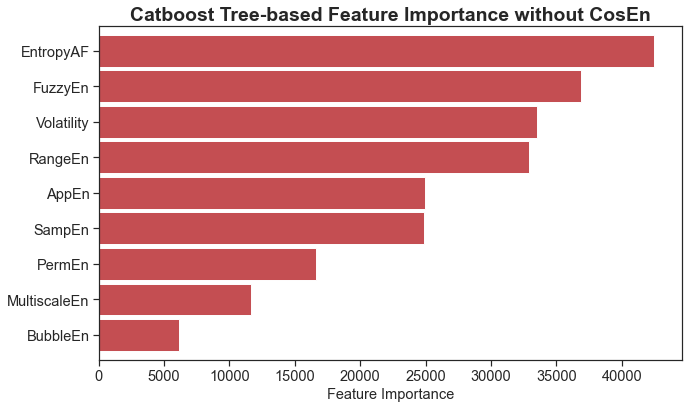

In [16]:
import matplotlib as mpl
df61 = average_importance.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df61.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Feature Importance", fontsize=15)
ax.set_title("Catboost Tree-based Feature Importance without CosEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()


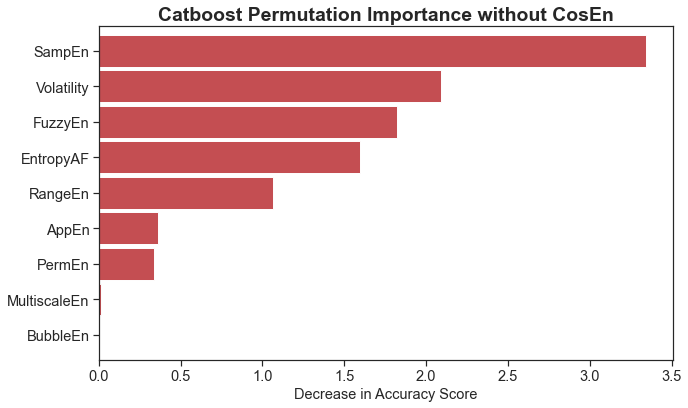

In [18]:
import matplotlib as mpl

# perm_imp_df = pd.DataFrame([perm_imp_dict])

# perm_imp_df_t = perm_imp_df.T
# perm_imp_df_t.columns = ["Importance"]
# perm_imp_df_t.sort_values(by=['Importance'],ascending=False)


df62 = perm_imp_df_t.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df62.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Decrease in Accuracy Score", fontsize=15)
ax.set_title("Catboost Permutation Importance without CosEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.xlim(0)
plt.tight_layout()
plt.show()


# No SampEn 

In [15]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
iterations_list = []
max_depth_list = []

from sklearn.inspection import permutation_importance
x_values = ['AppEn','CosEn','RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',]
y_values = ['Rhythm']
#for df in features_df_list:

zero_values_list = [0] * len(x_values)

perm_imp_dict = dict(zip(x_values,zero_values_list))

# Initialize dataframe with zeros
average_importance = pd.DataFrame({'Importance':np.zeros(len(x_values))}, 
                                  index = x_values)

counts = pd.DataFrame({'Count':np.zeros(len(x_values))}, 
                                  index = x_values)



df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()
    
    # Create CatBoost model
#     temp_model = CatBoostClassifier(learning_rate = 0.1, loss_function='Logloss')
#     param_distributions = {'iterations': randint(105, 110),
#                            'depth': randint(7,10)}
#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)


    model = CatBoostClassifier(iterations=106, learning_rate=0.1, depth=9, loss_function='Logloss')
    model.fit(X_train, y_train)
    
#     iterations_list.append(search.best_params_['iterations'])
#     max_depth_list.append(search.best_params_['depth'])
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
#     Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
#                           index = (X_train.columns))
#     Importance.sort_values(by = 'Importance', 
#                        axis = 0, 
#                        ascending = True).plot(kind = 'barh', 
#                                               color = 'r')
#     plt.xlabel('Variable Importance')
#     plt.gca().legend_ = None
    #plt.savefig('plot1.png')
    
    
    temp_importance = pd.DataFrame({'Importance':model.feature_importances_*100}, 
                          index = X_train.columns)
    for feature in X_train.columns:
        average_importance.loc[feature, 'Importance'] += temp_importance.loc[feature, 'Importance']
        counts.loc[feature, 'Count'] += 1
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

    for i in range(0,len(x_values)):
        perm_imp_dict[x_values[i]] += result.importances_mean[i]*100



elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

for i in range(0,len(x_values)):
    perm_imp_dict[x_values[i]] = perm_imp_dict[x_values[i]] / 23


0:	learn: 0.6167182	total: 14.6ms	remaining: 1.54s
1:	learn: 0.5559603	total: 24.4ms	remaining: 1.27s
2:	learn: 0.5028256	total: 33.7ms	remaining: 1.16s
3:	learn: 0.4585780	total: 42.7ms	remaining: 1.09s
4:	learn: 0.4200577	total: 52.7ms	remaining: 1.06s
5:	learn: 0.3862867	total: 61.7ms	remaining: 1.03s
6:	learn: 0.3574216	total: 70.8ms	remaining: 1s
7:	learn: 0.3319283	total: 79.5ms	remaining: 974ms
8:	learn: 0.3092278	total: 88.7ms	remaining: 956ms
9:	learn: 0.2894396	total: 97.3ms	remaining: 934ms
10:	learn: 0.2720838	total: 107ms	remaining: 923ms
11:	learn: 0.2564408	total: 115ms	remaining: 904ms
12:	learn: 0.2422773	total: 124ms	remaining: 888ms
13:	learn: 0.2298958	total: 133ms	remaining: 874ms
14:	learn: 0.2186595	total: 142ms	remaining: 860ms
15:	learn: 0.2088439	total: 151ms	remaining: 847ms
16:	learn: 0.1999329	total: 160ms	remaining: 835ms
17:	learn: 0.1920095	total: 168ms	remaining: 822ms
18:	learn: 0.1845163	total: 177ms	remaining: 809ms
19:	learn: 0.1780916	total: 185ms	

63:	learn: 0.1167393	total: 575ms	remaining: 377ms
64:	learn: 0.1163804	total: 584ms	remaining: 368ms
65:	learn: 0.1161061	total: 593ms	remaining: 359ms
66:	learn: 0.1158575	total: 601ms	remaining: 350ms
67:	learn: 0.1155564	total: 610ms	remaining: 341ms
68:	learn: 0.1153232	total: 618ms	remaining: 332ms
69:	learn: 0.1150295	total: 627ms	remaining: 322ms
70:	learn: 0.1147455	total: 635ms	remaining: 313ms
71:	learn: 0.1145636	total: 644ms	remaining: 304ms
72:	learn: 0.1142830	total: 653ms	remaining: 295ms
73:	learn: 0.1140382	total: 662ms	remaining: 286ms
74:	learn: 0.1137783	total: 670ms	remaining: 277ms
75:	learn: 0.1135088	total: 679ms	remaining: 268ms
76:	learn: 0.1132887	total: 688ms	remaining: 259ms
77:	learn: 0.1130671	total: 697ms	remaining: 250ms
78:	learn: 0.1127826	total: 706ms	remaining: 241ms
79:	learn: 0.1125008	total: 714ms	remaining: 232ms
80:	learn: 0.1122574	total: 723ms	remaining: 223ms
81:	learn: 0.1120803	total: 731ms	remaining: 214ms
82:	learn: 0.1118567	total: 740

21:	learn: 0.1634178	total: 210ms	remaining: 800ms
22:	learn: 0.1589596	total: 220ms	remaining: 794ms
23:	learn: 0.1546834	total: 229ms	remaining: 784ms
24:	learn: 0.1508688	total: 240ms	remaining: 776ms
25:	learn: 0.1474873	total: 249ms	remaining: 765ms
26:	learn: 0.1445040	total: 258ms	remaining: 755ms
27:	learn: 0.1415367	total: 268ms	remaining: 747ms
28:	learn: 0.1390049	total: 277ms	remaining: 736ms
29:	learn: 0.1366950	total: 287ms	remaining: 726ms
30:	learn: 0.1345019	total: 295ms	remaining: 715ms
31:	learn: 0.1327199	total: 305ms	remaining: 704ms
32:	learn: 0.1310223	total: 313ms	remaining: 693ms
33:	learn: 0.1294393	total: 322ms	remaining: 682ms
34:	learn: 0.1281676	total: 330ms	remaining: 670ms
35:	learn: 0.1265821	total: 339ms	remaining: 659ms
36:	learn: 0.1253513	total: 348ms	remaining: 649ms
37:	learn: 0.1241500	total: 357ms	remaining: 639ms
38:	learn: 0.1231582	total: 366ms	remaining: 629ms
39:	learn: 0.1219776	total: 376ms	remaining: 620ms
40:	learn: 0.1210417	total: 385

86:	learn: 0.1132413	total: 770ms	remaining: 168ms
87:	learn: 0.1131116	total: 779ms	remaining: 159ms
88:	learn: 0.1129440	total: 788ms	remaining: 151ms
89:	learn: 0.1128608	total: 797ms	remaining: 142ms
90:	learn: 0.1126580	total: 805ms	remaining: 133ms
91:	learn: 0.1125412	total: 814ms	remaining: 124ms
92:	learn: 0.1124052	total: 822ms	remaining: 115ms
93:	learn: 0.1121964	total: 830ms	remaining: 106ms
94:	learn: 0.1120567	total: 839ms	remaining: 97.1ms
95:	learn: 0.1119003	total: 848ms	remaining: 88.3ms
96:	learn: 0.1116801	total: 857ms	remaining: 79.5ms
97:	learn: 0.1114591	total: 866ms	remaining: 70.7ms
98:	learn: 0.1112508	total: 876ms	remaining: 61.9ms
99:	learn: 0.1110431	total: 885ms	remaining: 53.1ms
100:	learn: 0.1109344	total: 894ms	remaining: 44.3ms
101:	learn: 0.1106875	total: 902ms	remaining: 35.4ms
102:	learn: 0.1105206	total: 911ms	remaining: 26.5ms
103:	learn: 0.1103399	total: 919ms	remaining: 17.7ms
104:	learn: 0.1101539	total: 928ms	remaining: 8.84ms
105:	learn: 0.1

44:	learn: 0.1055142	total: 400ms	remaining: 542ms
45:	learn: 0.1047681	total: 410ms	remaining: 535ms
46:	learn: 0.1040709	total: 419ms	remaining: 525ms
47:	learn: 0.1035068	total: 428ms	remaining: 517ms
48:	learn: 0.1029623	total: 436ms	remaining: 507ms
49:	learn: 0.1023946	total: 445ms	remaining: 498ms
50:	learn: 0.1018940	total: 453ms	remaining: 489ms
51:	learn: 0.1014015	total: 462ms	remaining: 480ms
52:	learn: 0.1008551	total: 471ms	remaining: 471ms
53:	learn: 0.1004696	total: 480ms	remaining: 462ms
54:	learn: 0.1001206	total: 488ms	remaining: 453ms
55:	learn: 0.0997517	total: 497ms	remaining: 443ms
56:	learn: 0.0993305	total: 505ms	remaining: 434ms
57:	learn: 0.0990317	total: 514ms	remaining: 425ms
58:	learn: 0.0987466	total: 522ms	remaining: 416ms
59:	learn: 0.0983602	total: 531ms	remaining: 407ms
60:	learn: 0.0979030	total: 540ms	remaining: 399ms
61:	learn: 0.0976433	total: 549ms	remaining: 389ms
62:	learn: 0.0972543	total: 558ms	remaining: 381ms
63:	learn: 0.0969640	total: 566

100:	learn: 0.1107509	total: 984ms	remaining: 48.7ms
101:	learn: 0.1105002	total: 1s	remaining: 39.3ms
102:	learn: 0.1103132	total: 1.01s	remaining: 29.4ms
103:	learn: 0.1101761	total: 1.02s	remaining: 19.6ms
104:	learn: 0.1099877	total: 1.03s	remaining: 9.79ms
105:	learn: 0.1097918	total: 1.04s	remaining: 0us
0:	learn: 0.6169135	total: 9.69ms	remaining: 1.02s
1:	learn: 0.5561695	total: 19.7ms	remaining: 1.02s
2:	learn: 0.5030305	total: 29.5ms	remaining: 1.01s
3:	learn: 0.4577742	total: 39.1ms	remaining: 996ms
4:	learn: 0.4198858	total: 48.9ms	remaining: 988ms
5:	learn: 0.3867135	total: 58ms	remaining: 966ms
6:	learn: 0.3577992	total: 67.5ms	remaining: 955ms
7:	learn: 0.3326580	total: 77.2ms	remaining: 946ms
8:	learn: 0.3100931	total: 87ms	remaining: 938ms
9:	learn: 0.2904151	total: 97.4ms	remaining: 935ms
10:	learn: 0.2730626	total: 106ms	remaining: 919ms
11:	learn: 0.2573008	total: 116ms	remaining: 910ms
12:	learn: 0.2429493	total: 126ms	remaining: 899ms
13:	learn: 0.2308036	total: 1

63:	learn: 0.1174523	total: 588ms	remaining: 386ms
64:	learn: 0.1170647	total: 598ms	remaining: 377ms
65:	learn: 0.1168496	total: 606ms	remaining: 367ms
66:	learn: 0.1166444	total: 614ms	remaining: 358ms
67:	learn: 0.1163709	total: 623ms	remaining: 348ms
68:	learn: 0.1161446	total: 631ms	remaining: 339ms
69:	learn: 0.1159031	total: 640ms	remaining: 329ms
70:	learn: 0.1156539	total: 649ms	remaining: 320ms
71:	learn: 0.1153375	total: 657ms	remaining: 310ms
72:	learn: 0.1150886	total: 666ms	remaining: 301ms
73:	learn: 0.1148217	total: 675ms	remaining: 292ms
74:	learn: 0.1145094	total: 684ms	remaining: 283ms
75:	learn: 0.1142317	total: 692ms	remaining: 273ms
76:	learn: 0.1140147	total: 701ms	remaining: 264ms
77:	learn: 0.1138014	total: 709ms	remaining: 254ms
78:	learn: 0.1136078	total: 718ms	remaining: 245ms
79:	learn: 0.1133516	total: 727ms	remaining: 236ms
80:	learn: 0.1131380	total: 735ms	remaining: 227ms
81:	learn: 0.1129470	total: 744ms	remaining: 218ms
82:	learn: 0.1126782	total: 752

21:	learn: 0.1736222	total: 198ms	remaining: 755ms
22:	learn: 0.1688522	total: 207ms	remaining: 748ms
23:	learn: 0.1647147	total: 216ms	remaining: 737ms
24:	learn: 0.1609524	total: 225ms	remaining: 730ms
25:	learn: 0.1574978	total: 234ms	remaining: 720ms
26:	learn: 0.1544341	total: 243ms	remaining: 710ms
27:	learn: 0.1516766	total: 251ms	remaining: 699ms
28:	learn: 0.1490031	total: 260ms	remaining: 690ms
29:	learn: 0.1465307	total: 269ms	remaining: 682ms
30:	learn: 0.1441895	total: 278ms	remaining: 672ms
31:	learn: 0.1422203	total: 287ms	remaining: 664ms
32:	learn: 0.1403107	total: 296ms	remaining: 654ms
33:	learn: 0.1386907	total: 305ms	remaining: 646ms
34:	learn: 0.1370706	total: 314ms	remaining: 637ms
35:	learn: 0.1354933	total: 323ms	remaining: 627ms
36:	learn: 0.1341424	total: 331ms	remaining: 617ms
37:	learn: 0.1330619	total: 340ms	remaining: 608ms
38:	learn: 0.1317874	total: 348ms	remaining: 597ms
39:	learn: 0.1306332	total: 357ms	remaining: 589ms
40:	learn: 0.1297046	total: 365

83:	learn: 0.0952520	total: 777ms	remaining: 204ms
84:	learn: 0.0949856	total: 786ms	remaining: 194ms
85:	learn: 0.0947450	total: 795ms	remaining: 185ms
86:	learn: 0.0945700	total: 804ms	remaining: 176ms
87:	learn: 0.0943435	total: 813ms	remaining: 166ms
88:	learn: 0.0941614	total: 821ms	remaining: 157ms
89:	learn: 0.0940145	total: 830ms	remaining: 148ms
90:	learn: 0.0937263	total: 839ms	remaining: 138ms
91:	learn: 0.0936096	total: 848ms	remaining: 129ms
92:	learn: 0.0934459	total: 856ms	remaining: 120ms
93:	learn: 0.0932831	total: 865ms	remaining: 110ms
94:	learn: 0.0931270	total: 873ms	remaining: 101ms
95:	learn: 0.0930331	total: 881ms	remaining: 91.8ms
96:	learn: 0.0928869	total: 890ms	remaining: 82.6ms
97:	learn: 0.0926936	total: 898ms	remaining: 73.3ms
98:	learn: 0.0924990	total: 907ms	remaining: 64.1ms
99:	learn: 0.0923426	total: 915ms	remaining: 54.9ms
100:	learn: 0.0922330	total: 923ms	remaining: 45.7ms
101:	learn: 0.0920807	total: 932ms	remaining: 36.5ms
102:	learn: 0.0919133	

42:	learn: 0.1164887	total: 382ms	remaining: 560ms
43:	learn: 0.1158733	total: 391ms	remaining: 551ms
44:	learn: 0.1152522	total: 400ms	remaining: 542ms
45:	learn: 0.1146316	total: 409ms	remaining: 533ms
46:	learn: 0.1140190	total: 418ms	remaining: 525ms
47:	learn: 0.1135123	total: 427ms	remaining: 516ms
48:	learn: 0.1129550	total: 436ms	remaining: 507ms
49:	learn: 0.1123734	total: 445ms	remaining: 498ms
50:	learn: 0.1118447	total: 453ms	remaining: 489ms
51:	learn: 0.1113686	total: 462ms	remaining: 480ms
52:	learn: 0.1109028	total: 471ms	remaining: 471ms
53:	learn: 0.1104607	total: 480ms	remaining: 462ms
54:	learn: 0.1101197	total: 488ms	remaining: 453ms
55:	learn: 0.1098252	total: 497ms	remaining: 444ms
56:	learn: 0.1094354	total: 506ms	remaining: 435ms
57:	learn: 0.1091219	total: 515ms	remaining: 426ms
58:	learn: 0.1087913	total: 523ms	remaining: 417ms
59:	learn: 0.1084307	total: 532ms	remaining: 408ms
60:	learn: 0.1081620	total: 541ms	remaining: 399ms
61:	learn: 0.1078914	total: 549

0:	learn: 0.6175963	total: 9.53ms	remaining: 1s
1:	learn: 0.5576429	total: 18.9ms	remaining: 982ms
2:	learn: 0.5051400	total: 28ms	remaining: 962ms
3:	learn: 0.4611626	total: 37.5ms	remaining: 955ms
4:	learn: 0.4230039	total: 46.3ms	remaining: 936ms
5:	learn: 0.3898037	total: 55.2ms	remaining: 919ms
6:	learn: 0.3612699	total: 64ms	remaining: 905ms
7:	learn: 0.3362544	total: 72.9ms	remaining: 893ms
8:	learn: 0.3138670	total: 82ms	remaining: 884ms
9:	learn: 0.2944830	total: 90.5ms	remaining: 869ms
10:	learn: 0.2773678	total: 99.2ms	remaining: 857ms
11:	learn: 0.2619476	total: 108ms	remaining: 847ms
12:	learn: 0.2480551	total: 117ms	remaining: 839ms
13:	learn: 0.2356497	total: 126ms	remaining: 830ms
14:	learn: 0.2247188	total: 135ms	remaining: 821ms
15:	learn: 0.2154118	total: 145ms	remaining: 814ms
16:	learn: 0.2067559	total: 154ms	remaining: 805ms
17:	learn: 0.1991844	total: 163ms	remaining: 795ms
18:	learn: 0.1919266	total: 171ms	remaining: 785ms
19:	learn: 0.1856667	total: 180ms	remai

61:	learn: 0.1200189	total: 568ms	remaining: 403ms
62:	learn: 0.1196085	total: 577ms	remaining: 394ms
63:	learn: 0.1193037	total: 588ms	remaining: 386ms
64:	learn: 0.1189557	total: 597ms	remaining: 376ms
65:	learn: 0.1186384	total: 607ms	remaining: 368ms
66:	learn: 0.1184246	total: 616ms	remaining: 359ms
67:	learn: 0.1181775	total: 625ms	remaining: 349ms
68:	learn: 0.1179052	total: 635ms	remaining: 340ms
69:	learn: 0.1175806	total: 644ms	remaining: 331ms
70:	learn: 0.1173154	total: 655ms	remaining: 323ms
71:	learn: 0.1170433	total: 664ms	remaining: 313ms
72:	learn: 0.1167762	total: 673ms	remaining: 304ms
73:	learn: 0.1164070	total: 682ms	remaining: 295ms
74:	learn: 0.1162185	total: 691ms	remaining: 286ms
75:	learn: 0.1159492	total: 701ms	remaining: 277ms
76:	learn: 0.1157822	total: 709ms	remaining: 267ms
77:	learn: 0.1154560	total: 718ms	remaining: 258ms
78:	learn: 0.1152701	total: 727ms	remaining: 249ms
79:	learn: 0.1150218	total: 737ms	remaining: 239ms
80:	learn: 0.1148749	total: 746

21:	learn: 0.1740004	total: 198ms	remaining: 757ms
22:	learn: 0.1694242	total: 208ms	remaining: 751ms
23:	learn: 0.1651099	total: 217ms	remaining: 740ms
24:	learn: 0.1615487	total: 226ms	remaining: 732ms
25:	learn: 0.1581415	total: 235ms	remaining: 722ms
26:	learn: 0.1550342	total: 243ms	remaining: 712ms
27:	learn: 0.1521415	total: 252ms	remaining: 703ms
28:	learn: 0.1495191	total: 260ms	remaining: 692ms
29:	learn: 0.1469196	total: 270ms	remaining: 683ms
30:	learn: 0.1444914	total: 278ms	remaining: 673ms
31:	learn: 0.1427489	total: 287ms	remaining: 663ms
32:	learn: 0.1408551	total: 295ms	remaining: 653ms
33:	learn: 0.1390302	total: 305ms	remaining: 645ms
34:	learn: 0.1375426	total: 313ms	remaining: 636ms
35:	learn: 0.1360751	total: 322ms	remaining: 627ms
36:	learn: 0.1346590	total: 331ms	remaining: 617ms
37:	learn: 0.1333193	total: 340ms	remaining: 608ms
38:	learn: 0.1322317	total: 348ms	remaining: 598ms
39:	learn: 0.1311690	total: 357ms	remaining: 589ms
40:	learn: 0.1303614	total: 366

82:	learn: 0.1150028	total: 757ms	remaining: 210ms
83:	learn: 0.1147895	total: 767ms	remaining: 201ms
84:	learn: 0.1145291	total: 776ms	remaining: 192ms
85:	learn: 0.1143185	total: 785ms	remaining: 182ms
86:	learn: 0.1140807	total: 794ms	remaining: 173ms
87:	learn: 0.1139611	total: 803ms	remaining: 164ms
88:	learn: 0.1137386	total: 812ms	remaining: 155ms
89:	learn: 0.1136076	total: 821ms	remaining: 146ms
90:	learn: 0.1134480	total: 829ms	remaining: 137ms
91:	learn: 0.1133234	total: 838ms	remaining: 128ms
92:	learn: 0.1131428	total: 847ms	remaining: 118ms
93:	learn: 0.1128824	total: 857ms	remaining: 109ms
94:	learn: 0.1126516	total: 866ms	remaining: 100ms
95:	learn: 0.1124719	total: 875ms	remaining: 91.2ms
96:	learn: 0.1123078	total: 884ms	remaining: 82ms
97:	learn: 0.1120977	total: 893ms	remaining: 72.9ms
98:	learn: 0.1118155	total: 902ms	remaining: 63.8ms
99:	learn: 0.1116870	total: 911ms	remaining: 54.7ms
100:	learn: 0.1115808	total: 920ms	remaining: 45.5ms
101:	learn: 0.1114662	tota

44:	learn: 0.1279356	total: 399ms	remaining: 540ms
45:	learn: 0.1271191	total: 408ms	remaining: 533ms
46:	learn: 0.1263684	total: 418ms	remaining: 524ms
47:	learn: 0.1257064	total: 426ms	remaining: 515ms
48:	learn: 0.1250698	total: 436ms	remaining: 507ms
49:	learn: 0.1245097	total: 445ms	remaining: 498ms
50:	learn: 0.1241684	total: 454ms	remaining: 490ms
51:	learn: 0.1236869	total: 463ms	remaining: 481ms
52:	learn: 0.1232593	total: 473ms	remaining: 473ms
53:	learn: 0.1227655	total: 482ms	remaining: 464ms
54:	learn: 0.1223654	total: 491ms	remaining: 455ms
55:	learn: 0.1220185	total: 500ms	remaining: 446ms
56:	learn: 0.1216237	total: 508ms	remaining: 437ms
57:	learn: 0.1212050	total: 517ms	remaining: 428ms
58:	learn: 0.1208184	total: 526ms	remaining: 419ms
59:	learn: 0.1205312	total: 535ms	remaining: 410ms
60:	learn: 0.1202554	total: 544ms	remaining: 401ms
61:	learn: 0.1199978	total: 553ms	remaining: 393ms
62:	learn: 0.1196234	total: 563ms	remaining: 384ms
63:	learn: 0.1193567	total: 572

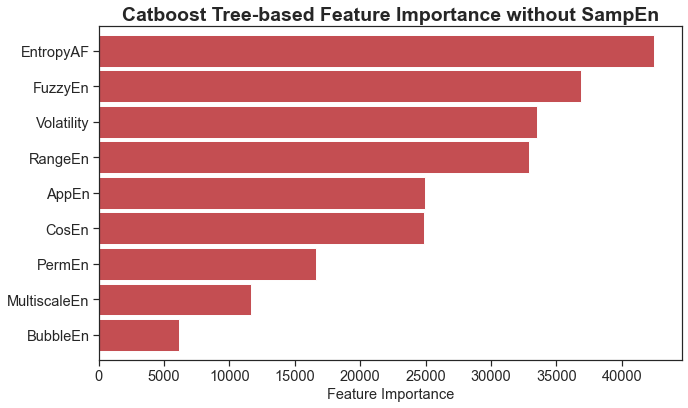

In [16]:
import matplotlib as mpl
df61 = average_importance.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df61.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Feature Importance", fontsize=15)
ax.set_title("Catboost Tree-based Feature Importance without SampEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()


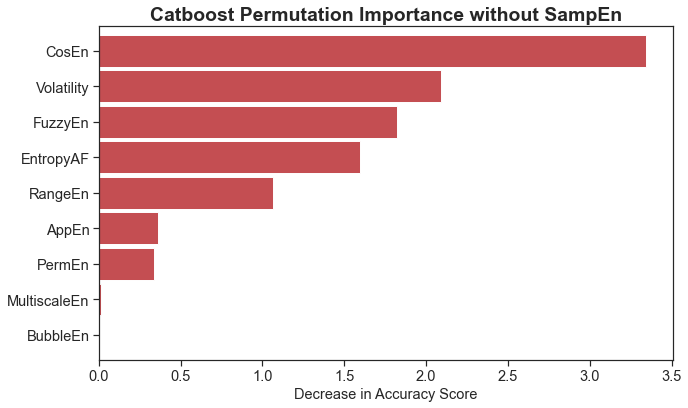

In [17]:
import matplotlib as mpl

perm_imp_df = pd.DataFrame([perm_imp_dict])

perm_imp_df_t = perm_imp_df.T
perm_imp_df_t.columns = ["Importance"]
perm_imp_df_t.sort_values(by=['Importance'],ascending=False)


df62 = perm_imp_df_t.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df62.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Decrease in Accuracy Score", fontsize=15)
ax.set_title("Catboost Permutation Importance without SampEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.xlim(0)
plt.tight_layout()
plt.show()


In [12]:
print(confusion_matrix(Truth, Output))
print(classification_report(Truth, Output))
print(acc_score)
print(elapsed)

[[23166  1577]
 [ 1692 18533]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.93     24743
           1       0.92      0.92      0.92     20225

    accuracy                           0.93     44968
   macro avg       0.93      0.93      0.93     44968
weighted avg       0.93      0.93      0.93     44968

[0.914187643020595, 0.9578093306288032, 0.9949622166246851, 0.9310551558752997, 0.9968652037617555, 0.9594320486815415, 0.7585240541802896, 0.998638529611981, 0.9397590361445783, 0.9735391400220507, 0.9818511796733213, 0.990667623833453, 0.8476190476190476, 0.954140127388535, 0.6232306411323897, 0.9902525476295968, 0.9897189856065799, 0.9849971148297749, 0.7497886728655959, 0.9686641011544805, 0.9957228400342173, 0.9981167608286252, 0.9966173361522199]
100.3481230000034


# No SampEn or CosEn

In [18]:
#Implementing cross validation 
kf = KFold(n_splits=23, shuffle=False)

from time import time
import timeit #imports timeit module
start_time = timeit.default_timer() #defines start time so computational time can be calculated

acc_score = [];
Truth = [];
Output = [];
iterations_list = []
max_depth_list = []

from sklearn.inspection import permutation_importance
x_values = ['AppEn','RangeEn', 'FuzzyEn',
       'EntropyAF', 'PermEn', 'BubbleEn', 'MultiscaleEn', 'Volatility',]
y_values = ['Rhythm']
#for df in features_df_list:

zero_values_list = [0] * len(x_values)

perm_imp_dict = dict(zip(x_values,zero_values_list))

# Initialize dataframe with zeros
average_importance = pd.DataFrame({'Importance':np.zeros(len(x_values))}, 
                                  index = x_values)

counts = pd.DataFrame({'Count':np.zeros(len(x_values))}, 
                                  index = x_values)



df = features_maindf

for idx, subject in enumerate(good_list):
    
    train_index = ~df['Subject'].str.contains(subject)
    test_index = df['Subject'].str.contains(subject)
    X_train , X_test = df.loc[train_index,x_values], df.loc[test_index,x_values]
    y_train , y_test = df.loc[train_index,y_values].values.ravel(), df.loc[test_index,y_values].values.ravel()
    
    # Create CatBoost model
#     temp_model = CatBoostClassifier(learning_rate = 0.1, loss_function='Logloss')
#     param_distributions = {'iterations': randint(105, 110),
#                            'depth': randint(7,10)}
#     search = RandomizedSearchCV(estimator=temp_model, param_distributions=param_distributions, random_state=0)
#     search.fit(X_train, y_train)


    model = CatBoostClassifier(iterations=106, learning_rate=0.1, depth=9, loss_function='Logloss')
    model.fit(X_train, y_train)
    
#     iterations_list.append(search.best_params_['iterations'])
#     max_depth_list.append(search.best_params_['depth'])
    
    # make the prediction using the resulting model
    pred_values = model.predict(X_test)
    #preds_proba = model.predict_proba(test_data)
    #print("class = ", preds_class)
    #print("proba = ", preds_proba)
     
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    
    Truth.extend(y_test.reshape(y_test.shape[0])); ## it is a list
    Output.extend(pred_values); ## it is a list  
    
    #print(model.feature_importances_)
#     Importance = pd.DataFrame({'Importance':(model.feature_importances_*100)}, 
#                           index = (X_train.columns))
#     Importance.sort_values(by = 'Importance', 
#                        axis = 0, 
#                        ascending = True).plot(kind = 'barh', 
#                                               color = 'r')
#     plt.xlabel('Variable Importance')
#     plt.gca().legend_ = None
    #plt.savefig('plot1.png')
    
    
    temp_importance = pd.DataFrame({'Importance':model.feature_importances_*100}, 
                          index = X_train.columns)
    for feature in X_train.columns:
        average_importance.loc[feature, 'Importance'] += temp_importance.loc[feature, 'Importance']
        counts.loc[feature, 'Count'] += 1
    
    result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=0)

    for i in range(0,len(x_values)):
        perm_imp_dict[x_values[i]] += result.importances_mean[i]*100



elapsed = timeit.default_timer() - start_time #gives total computation time
print("---Run time is %s seconds ---" % elapsed) #prints computation time
print()

print('Accuracy of each fold: \n {}'.format(acc_score))
print()
try: 
    print('Avg accuracy : \n{}'.format(np.mean(acc_score))); 
except: 
    print('hi')
print()
print('Std of accuracy : \n{}'.format(np.std(acc_score)))

for i in range(0,len(x_values)):
    perm_imp_dict[x_values[i]] = perm_imp_dict[x_values[i]] / 23


0:	learn: 0.6168067	total: 9.45ms	remaining: 992ms
1:	learn: 0.5544095	total: 18ms	remaining: 934ms
2:	learn: 0.5022224	total: 26.9ms	remaining: 924ms
3:	learn: 0.4569889	total: 35.4ms	remaining: 903ms
4:	learn: 0.4196861	total: 44.4ms	remaining: 897ms
5:	learn: 0.3859485	total: 53.1ms	remaining: 886ms
6:	learn: 0.3572810	total: 61.6ms	remaining: 872ms
7:	learn: 0.3315716	total: 69.9ms	remaining: 856ms
8:	learn: 0.3097014	total: 78.8ms	remaining: 849ms
9:	learn: 0.2901084	total: 87.4ms	remaining: 839ms
10:	learn: 0.2723760	total: 95.9ms	remaining: 829ms
11:	learn: 0.2564442	total: 105ms	remaining: 820ms
12:	learn: 0.2427349	total: 113ms	remaining: 809ms
13:	learn: 0.2301127	total: 121ms	remaining: 798ms
14:	learn: 0.2192903	total: 130ms	remaining: 789ms
15:	learn: 0.2096520	total: 139ms	remaining: 781ms
16:	learn: 0.2012290	total: 147ms	remaining: 770ms
17:	learn: 0.1932392	total: 156ms	remaining: 763ms
18:	learn: 0.1859124	total: 164ms	remaining: 753ms
19:	learn: 0.1792456	total: 173m

66:	learn: 0.1180300	total: 573ms	remaining: 333ms
67:	learn: 0.1177240	total: 583ms	remaining: 326ms
68:	learn: 0.1175078	total: 593ms	remaining: 318ms
69:	learn: 0.1171870	total: 602ms	remaining: 310ms
70:	learn: 0.1169751	total: 611ms	remaining: 301ms
71:	learn: 0.1167343	total: 620ms	remaining: 293ms
72:	learn: 0.1164331	total: 628ms	remaining: 284ms
73:	learn: 0.1161520	total: 637ms	remaining: 275ms
74:	learn: 0.1159159	total: 646ms	remaining: 267ms
75:	learn: 0.1156702	total: 655ms	remaining: 258ms
76:	learn: 0.1154297	total: 663ms	remaining: 250ms
77:	learn: 0.1152450	total: 672ms	remaining: 241ms
78:	learn: 0.1150604	total: 681ms	remaining: 233ms
79:	learn: 0.1149119	total: 690ms	remaining: 224ms
80:	learn: 0.1146922	total: 699ms	remaining: 216ms
81:	learn: 0.1144397	total: 707ms	remaining: 207ms
82:	learn: 0.1142064	total: 716ms	remaining: 198ms
83:	learn: 0.1140564	total: 725ms	remaining: 190ms
84:	learn: 0.1138214	total: 734ms	remaining: 181ms
85:	learn: 0.1136932	total: 743

21:	learn: 0.1638175	total: 208ms	remaining: 795ms
22:	learn: 0.1591880	total: 218ms	remaining: 788ms
23:	learn: 0.1552274	total: 228ms	remaining: 779ms
24:	learn: 0.1513808	total: 238ms	remaining: 771ms
25:	learn: 0.1480035	total: 247ms	remaining: 761ms
26:	learn: 0.1450375	total: 257ms	remaining: 752ms
27:	learn: 0.1422934	total: 267ms	remaining: 743ms
28:	learn: 0.1397195	total: 277ms	remaining: 734ms
29:	learn: 0.1373950	total: 286ms	remaining: 725ms
30:	learn: 0.1352569	total: 296ms	remaining: 715ms
31:	learn: 0.1332167	total: 305ms	remaining: 706ms
32:	learn: 0.1315019	total: 315ms	remaining: 697ms
33:	learn: 0.1300310	total: 325ms	remaining: 688ms
34:	learn: 0.1284480	total: 335ms	remaining: 679ms
35:	learn: 0.1270798	total: 344ms	remaining: 669ms
36:	learn: 0.1256523	total: 354ms	remaining: 660ms
37:	learn: 0.1244976	total: 363ms	remaining: 650ms
38:	learn: 0.1233920	total: 373ms	remaining: 641ms
39:	learn: 0.1223916	total: 383ms	remaining: 631ms
40:	learn: 0.1215932	total: 392

86:	learn: 0.1152803	total: 786ms	remaining: 172ms
87:	learn: 0.1150964	total: 796ms	remaining: 163ms
88:	learn: 0.1148820	total: 805ms	remaining: 154ms
89:	learn: 0.1147624	total: 813ms	remaining: 145ms
90:	learn: 0.1145827	total: 822ms	remaining: 136ms
91:	learn: 0.1144016	total: 831ms	remaining: 126ms
92:	learn: 0.1142401	total: 839ms	remaining: 117ms
93:	learn: 0.1140730	total: 847ms	remaining: 108ms
94:	learn: 0.1138933	total: 856ms	remaining: 99.1ms
95:	learn: 0.1137587	total: 865ms	remaining: 90.1ms
96:	learn: 0.1134831	total: 873ms	remaining: 81ms
97:	learn: 0.1133213	total: 883ms	remaining: 72.1ms
98:	learn: 0.1131870	total: 891ms	remaining: 63ms
99:	learn: 0.1130800	total: 900ms	remaining: 54ms
100:	learn: 0.1129998	total: 908ms	remaining: 45ms
101:	learn: 0.1129542	total: 917ms	remaining: 36ms
102:	learn: 0.1127646	total: 925ms	remaining: 27ms
103:	learn: 0.1126254	total: 934ms	remaining: 18ms
104:	learn: 0.1124397	total: 943ms	remaining: 8.98ms
105:	learn: 0.1122339	total: 

45:	learn: 0.1065021	total: 398ms	remaining: 519ms
46:	learn: 0.1057716	total: 407ms	remaining: 511ms
47:	learn: 0.1051871	total: 415ms	remaining: 502ms
48:	learn: 0.1045465	total: 424ms	remaining: 494ms
49:	learn: 0.1040654	total: 433ms	remaining: 485ms
50:	learn: 0.1034848	total: 443ms	remaining: 477ms
51:	learn: 0.1030453	total: 451ms	remaining: 468ms
52:	learn: 0.1025450	total: 460ms	remaining: 460ms
53:	learn: 0.1019705	total: 469ms	remaining: 451ms
54:	learn: 0.1014831	total: 478ms	remaining: 443ms
55:	learn: 0.1011297	total: 487ms	remaining: 434ms
56:	learn: 0.1007006	total: 495ms	remaining: 426ms
57:	learn: 0.1002759	total: 504ms	remaining: 417ms
58:	learn: 0.0999006	total: 513ms	remaining: 409ms
59:	learn: 0.0995876	total: 521ms	remaining: 400ms
60:	learn: 0.0992089	total: 531ms	remaining: 392ms
61:	learn: 0.0988882	total: 541ms	remaining: 384ms
62:	learn: 0.0985712	total: 549ms	remaining: 375ms
63:	learn: 0.0982248	total: 558ms	remaining: 366ms
64:	learn: 0.0979415	total: 568

0:	learn: 0.6164805	total: 9.4ms	remaining: 987ms
1:	learn: 0.5546404	total: 18ms	remaining: 936ms
2:	learn: 0.5023558	total: 26.5ms	remaining: 910ms
3:	learn: 0.4577005	total: 35.3ms	remaining: 900ms
4:	learn: 0.4200536	total: 43.8ms	remaining: 886ms
5:	learn: 0.3865748	total: 52.3ms	remaining: 871ms
6:	learn: 0.3576161	total: 60.6ms	remaining: 857ms
7:	learn: 0.3318272	total: 69.2ms	remaining: 847ms
8:	learn: 0.3098219	total: 77.7ms	remaining: 837ms
9:	learn: 0.2903582	total: 86.1ms	remaining: 826ms
10:	learn: 0.2727230	total: 95.1ms	remaining: 822ms
11:	learn: 0.2574234	total: 104ms	remaining: 817ms
12:	learn: 0.2437175	total: 113ms	remaining: 811ms
13:	learn: 0.2309391	total: 122ms	remaining: 800ms
14:	learn: 0.2201146	total: 130ms	remaining: 789ms
15:	learn: 0.2103151	total: 138ms	remaining: 777ms
16:	learn: 0.2019970	total: 147ms	remaining: 769ms
17:	learn: 0.1941486	total: 155ms	remaining: 759ms
18:	learn: 0.1868085	total: 164ms	remaining: 750ms
19:	learn: 0.1806332	total: 172ms

65:	learn: 0.1186429	total: 576ms	remaining: 349ms
66:	learn: 0.1183565	total: 586ms	remaining: 341ms
67:	learn: 0.1181355	total: 595ms	remaining: 332ms
68:	learn: 0.1178016	total: 604ms	remaining: 324ms
69:	learn: 0.1175339	total: 612ms	remaining: 315ms
70:	learn: 0.1172733	total: 621ms	remaining: 306ms
71:	learn: 0.1170229	total: 629ms	remaining: 297ms
72:	learn: 0.1168064	total: 638ms	remaining: 289ms
73:	learn: 0.1165591	total: 647ms	remaining: 280ms
74:	learn: 0.1162999	total: 656ms	remaining: 271ms
75:	learn: 0.1161114	total: 665ms	remaining: 262ms
76:	learn: 0.1159146	total: 673ms	remaining: 253ms
77:	learn: 0.1157093	total: 682ms	remaining: 245ms
78:	learn: 0.1154879	total: 691ms	remaining: 236ms
79:	learn: 0.1152229	total: 700ms	remaining: 227ms
80:	learn: 0.1150170	total: 708ms	remaining: 219ms
81:	learn: 0.1147868	total: 717ms	remaining: 210ms
82:	learn: 0.1146385	total: 726ms	remaining: 201ms
83:	learn: 0.1144414	total: 734ms	remaining: 192ms
84:	learn: 0.1142299	total: 743

22:	learn: 0.1699916	total: 202ms	remaining: 728ms
23:	learn: 0.1657946	total: 211ms	remaining: 720ms
24:	learn: 0.1622072	total: 220ms	remaining: 712ms
25:	learn: 0.1588202	total: 228ms	remaining: 701ms
26:	learn: 0.1554439	total: 236ms	remaining: 691ms
27:	learn: 0.1525539	total: 244ms	remaining: 680ms
28:	learn: 0.1498191	total: 253ms	remaining: 673ms
29:	learn: 0.1472675	total: 262ms	remaining: 663ms
30:	learn: 0.1451315	total: 271ms	remaining: 656ms
31:	learn: 0.1431861	total: 279ms	remaining: 646ms
32:	learn: 0.1415790	total: 288ms	remaining: 638ms
33:	learn: 0.1400358	total: 297ms	remaining: 628ms
34:	learn: 0.1383330	total: 305ms	remaining: 620ms
35:	learn: 0.1369335	total: 314ms	remaining: 610ms
36:	learn: 0.1357060	total: 323ms	remaining: 602ms
37:	learn: 0.1344221	total: 331ms	remaining: 592ms
38:	learn: 0.1332549	total: 339ms	remaining: 583ms
39:	learn: 0.1322871	total: 348ms	remaining: 574ms
40:	learn: 0.1312230	total: 356ms	remaining: 564ms
41:	learn: 0.1303620	total: 364

84:	learn: 0.0960949	total: 764ms	remaining: 189ms
85:	learn: 0.0959200	total: 774ms	remaining: 180ms
86:	learn: 0.0957085	total: 784ms	remaining: 171ms
87:	learn: 0.0955951	total: 794ms	remaining: 162ms
88:	learn: 0.0954385	total: 803ms	remaining: 153ms
89:	learn: 0.0952766	total: 813ms	remaining: 145ms
90:	learn: 0.0950099	total: 823ms	remaining: 136ms
91:	learn: 0.0948738	total: 831ms	remaining: 126ms
92:	learn: 0.0947073	total: 840ms	remaining: 117ms
93:	learn: 0.0945396	total: 849ms	remaining: 108ms
94:	learn: 0.0943939	total: 858ms	remaining: 99.4ms
95:	learn: 0.0942536	total: 867ms	remaining: 90.3ms
96:	learn: 0.0940006	total: 876ms	remaining: 81.3ms
97:	learn: 0.0937806	total: 885ms	remaining: 72.3ms
98:	learn: 0.0936704	total: 894ms	remaining: 63.2ms
99:	learn: 0.0934614	total: 904ms	remaining: 54.3ms
100:	learn: 0.0932378	total: 915ms	remaining: 45.3ms
101:	learn: 0.0930546	total: 925ms	remaining: 36.3ms
102:	learn: 0.0928781	total: 934ms	remaining: 27.2ms
103:	learn: 0.09271

45:	learn: 0.1156887	total: 400ms	remaining: 521ms
46:	learn: 0.1151047	total: 410ms	remaining: 515ms
47:	learn: 0.1145525	total: 420ms	remaining: 508ms
48:	learn: 0.1140558	total: 431ms	remaining: 501ms
49:	learn: 0.1136270	total: 440ms	remaining: 493ms
50:	learn: 0.1131302	total: 451ms	remaining: 486ms
51:	learn: 0.1127002	total: 461ms	remaining: 479ms
52:	learn: 0.1122498	total: 470ms	remaining: 470ms
53:	learn: 0.1117307	total: 481ms	remaining: 463ms
54:	learn: 0.1112452	total: 491ms	remaining: 455ms
55:	learn: 0.1108995	total: 500ms	remaining: 446ms
56:	learn: 0.1106199	total: 511ms	remaining: 439ms
57:	learn: 0.1102825	total: 519ms	remaining: 430ms
58:	learn: 0.1099642	total: 530ms	remaining: 422ms
59:	learn: 0.1096467	total: 539ms	remaining: 413ms
60:	learn: 0.1092943	total: 548ms	remaining: 404ms
61:	learn: 0.1089598	total: 557ms	remaining: 396ms
62:	learn: 0.1086830	total: 566ms	remaining: 386ms
63:	learn: 0.1084117	total: 576ms	remaining: 378ms
64:	learn: 0.1082154	total: 584

0:	learn: 0.6171383	total: 11.1ms	remaining: 1.17s
1:	learn: 0.5556661	total: 20.5ms	remaining: 1.06s
2:	learn: 0.5042319	total: 30ms	remaining: 1.03s
3:	learn: 0.4598936	total: 40.1ms	remaining: 1.02s
4:	learn: 0.4230131	total: 49.4ms	remaining: 999ms
5:	learn: 0.3897928	total: 59.4ms	remaining: 990ms
6:	learn: 0.3611161	total: 69.2ms	remaining: 978ms
7:	learn: 0.3356146	total: 79.4ms	remaining: 973ms
8:	learn: 0.3134990	total: 89.2ms	remaining: 962ms
9:	learn: 0.2942136	total: 99.1ms	remaining: 952ms
10:	learn: 0.2771018	total: 109ms	remaining: 941ms
11:	learn: 0.2616894	total: 119ms	remaining: 935ms
12:	learn: 0.2484412	total: 129ms	remaining: 923ms
13:	learn: 0.2364407	total: 140ms	remaining: 921ms
14:	learn: 0.2259048	total: 153ms	remaining: 926ms
15:	learn: 0.2164212	total: 162ms	remaining: 914ms
16:	learn: 0.2076227	total: 175ms	remaining: 916ms
17:	learn: 0.1999016	total: 186ms	remaining: 908ms
18:	learn: 0.1927543	total: 196ms	remaining: 899ms
19:	learn: 0.1861420	total: 207ms

62:	learn: 0.1214799	total: 561ms	remaining: 383ms
63:	learn: 0.1211932	total: 571ms	remaining: 375ms
64:	learn: 0.1209169	total: 580ms	remaining: 366ms
65:	learn: 0.1205889	total: 589ms	remaining: 357ms
66:	learn: 0.1203042	total: 597ms	remaining: 348ms
67:	learn: 0.1199677	total: 606ms	remaining: 339ms
68:	learn: 0.1197488	total: 615ms	remaining: 330ms
69:	learn: 0.1194368	total: 624ms	remaining: 321ms
70:	learn: 0.1192111	total: 634ms	remaining: 312ms
71:	learn: 0.1189405	total: 643ms	remaining: 303ms
72:	learn: 0.1186938	total: 652ms	remaining: 295ms
73:	learn: 0.1184544	total: 660ms	remaining: 286ms
74:	learn: 0.1182210	total: 669ms	remaining: 276ms
75:	learn: 0.1180028	total: 678ms	remaining: 267ms
76:	learn: 0.1178047	total: 687ms	remaining: 259ms
77:	learn: 0.1175620	total: 695ms	remaining: 250ms
78:	learn: 0.1174249	total: 704ms	remaining: 240ms
79:	learn: 0.1172210	total: 713ms	remaining: 232ms
80:	learn: 0.1169606	total: 722ms	remaining: 223ms
81:	learn: 0.1167901	total: 730

22:	learn: 0.1718996	total: 199ms	remaining: 717ms
23:	learn: 0.1677393	total: 207ms	remaining: 708ms
24:	learn: 0.1636575	total: 216ms	remaining: 699ms
25:	learn: 0.1603240	total: 224ms	remaining: 688ms
26:	learn: 0.1572648	total: 233ms	remaining: 680ms
27:	learn: 0.1543665	total: 241ms	remaining: 671ms
28:	learn: 0.1516928	total: 249ms	remaining: 662ms
29:	learn: 0.1494698	total: 257ms	remaining: 652ms
30:	learn: 0.1471965	total: 266ms	remaining: 643ms
31:	learn: 0.1449841	total: 274ms	remaining: 633ms
32:	learn: 0.1433344	total: 282ms	remaining: 625ms
33:	learn: 0.1420270	total: 291ms	remaining: 615ms
34:	learn: 0.1404457	total: 299ms	remaining: 607ms
35:	learn: 0.1388433	total: 308ms	remaining: 598ms
36:	learn: 0.1373916	total: 316ms	remaining: 589ms
37:	learn: 0.1361289	total: 324ms	remaining: 580ms
38:	learn: 0.1349996	total: 332ms	remaining: 571ms
39:	learn: 0.1339170	total: 340ms	remaining: 561ms
40:	learn: 0.1328218	total: 349ms	remaining: 553ms
41:	learn: 0.1320345	total: 357

84:	learn: 0.1172708	total: 766ms	remaining: 189ms
85:	learn: 0.1170476	total: 776ms	remaining: 180ms
86:	learn: 0.1168218	total: 787ms	remaining: 172ms
87:	learn: 0.1165985	total: 796ms	remaining: 163ms
88:	learn: 0.1164386	total: 805ms	remaining: 154ms
89:	learn: 0.1162602	total: 814ms	remaining: 145ms
90:	learn: 0.1160939	total: 823ms	remaining: 136ms
91:	learn: 0.1159596	total: 833ms	remaining: 127ms
92:	learn: 0.1156997	total: 842ms	remaining: 118ms
93:	learn: 0.1155321	total: 851ms	remaining: 109ms
94:	learn: 0.1153475	total: 860ms	remaining: 99.5ms
95:	learn: 0.1151821	total: 869ms	remaining: 90.5ms
96:	learn: 0.1149608	total: 878ms	remaining: 81.5ms
97:	learn: 0.1147796	total: 887ms	remaining: 72.4ms
98:	learn: 0.1145901	total: 896ms	remaining: 63.4ms
99:	learn: 0.1144279	total: 905ms	remaining: 54.3ms
100:	learn: 0.1142339	total: 914ms	remaining: 45.3ms
101:	learn: 0.1140772	total: 923ms	remaining: 36.2ms
102:	learn: 0.1138378	total: 933ms	remaining: 27.2ms
103:	learn: 0.11369

44:	learn: 0.1301430	total: 403ms	remaining: 547ms
45:	learn: 0.1294165	total: 413ms	remaining: 538ms
46:	learn: 0.1288450	total: 422ms	remaining: 529ms
47:	learn: 0.1282229	total: 431ms	remaining: 520ms
48:	learn: 0.1276892	total: 439ms	remaining: 511ms
49:	learn: 0.1272691	total: 448ms	remaining: 502ms
50:	learn: 0.1268095	total: 457ms	remaining: 492ms
51:	learn: 0.1262768	total: 465ms	remaining: 483ms
52:	learn: 0.1259073	total: 474ms	remaining: 474ms
53:	learn: 0.1255160	total: 482ms	remaining: 465ms
54:	learn: 0.1250217	total: 491ms	remaining: 456ms
55:	learn: 0.1246881	total: 500ms	remaining: 446ms
56:	learn: 0.1243611	total: 509ms	remaining: 437ms
57:	learn: 0.1239925	total: 517ms	remaining: 428ms
58:	learn: 0.1235160	total: 526ms	remaining: 419ms
59:	learn: 0.1231937	total: 535ms	remaining: 410ms
60:	learn: 0.1228527	total: 543ms	remaining: 401ms
61:	learn: 0.1225493	total: 552ms	remaining: 392ms
62:	learn: 0.1222179	total: 560ms	remaining: 382ms
63:	learn: 0.1218500	total: 569

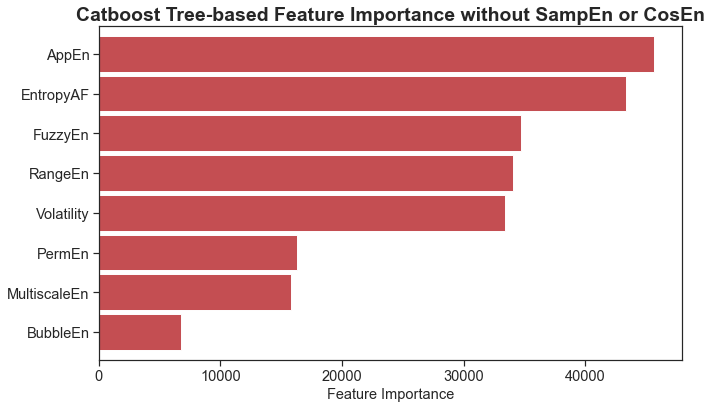

In [19]:
import matplotlib as mpl
df61 = average_importance.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df61.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Feature Importance", fontsize=15)
ax.set_title("Catboost Tree-based Feature Importance without SampEn or CosEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()


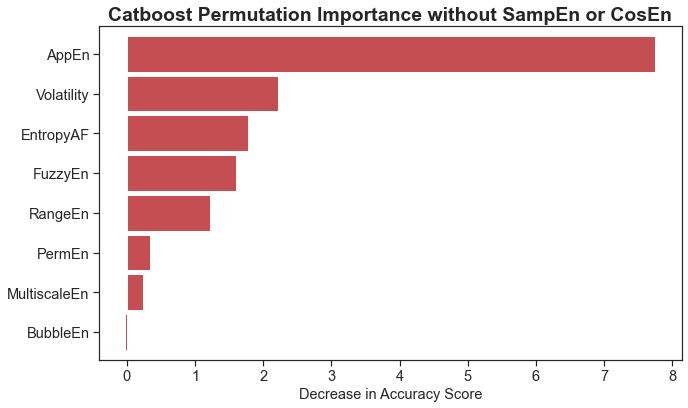

In [20]:
import matplotlib as mpl

perm_imp_df = pd.DataFrame([perm_imp_dict])

perm_imp_df_t = perm_imp_df.T
perm_imp_df_t.columns = ["Importance"]
perm_imp_df_t.sort_values(by=['Importance'],ascending=False)


df62 = perm_imp_df_t.sort_values(by='Importance', axis=0, ascending=True)

mpl.rcParams['font.family'] = 'Arial'

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Create the plot
df62.plot(kind='barh', color='r', ax=ax, legend=False,width=0.9)

# Set axes labels and title
ax.set_xlabel("Decrease in Accuracy Score", fontsize=15)
ax.set_title("Catboost Permutation Importance without SampEn or CosEn", fontsize=20, weight='bold')

# Make the axes labels bigger
ax.tick_params(axis='both', which='major', labelsize=15)

plt.tight_layout()
plt.show()
